In [ ]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

#Reading the Dataset

In [ ]:
trans=transforms.ToTensor()

In [ ]:
usps_train= torchvision.datasets.USPS(root="../data", train=True, transform=trans, download=True)
usps_test= torchvision.datasets.USPS(root="../data", train=False ,transform=trans, download=True)

In [ ]:
len(usps_train), len(usps_test)

(7291, 2007)

In [ ]:
usps_train[0][0].shape

torch.Size([1, 16, 16])

In [ ]:
def get_usps_labels(labels):
    text_labels=['0','1','2','3','4','5','6','7','8','9']
    return [text_labels[int(i)] for i in labels]

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale =1.5):
  figsize=(num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img) :
      ax.imshow(img.numpy())
    else :
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

In [ ]:
X,y = next(iter(data.DataLoader(usps_train, batch_size=12)))

array([<AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'0'}>], dtype=object)

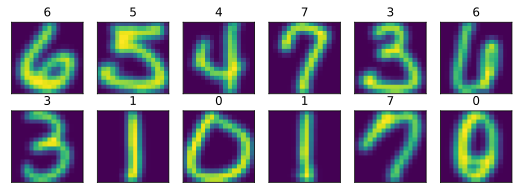

In [ ]:
show_images(X.reshape(12,16,16), 2,6,titles=get_usps_labels(y))

#Reading a Minibatch

In [ ]:
batch_size = 400

def get_dataloader_workers():
  return 4

train_iter = data.DataLoader(usps_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
timer = d2l.Timer()
for X,y in train_iter:
  continue
f'{timer.stop() : .2f} sec'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


' 0.84 sec'

In [ ]:
def load_data_usps(batch_size, resize=None):
  trans = [transforms.ToTensor()]   
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  usps_train= torchvision.datasets.USPS(root="../data", train=True, transform=trans, download=True)
  usps_test= torchvision.datasets.USPS(root="../data", train=False ,transform=trans, download=True)
  return (data.DataLoader(usps_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
          data.DataLoader(usps_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [ ]:
train_iter, test_iter = load_data_usps(123, resize=64)
for X,y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([123, 1, 64, 64]) torch.float32 torch.Size([123]) torch.int64


In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 400
train_iter, test_iter = load_data_usps(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Initializing Model Parameters

In [ ]:
num_inputs = 256 #16*16
num_outputs = 10 # class 수

W = torch.normal(0,0.01, size = (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad= True)

#Defining the Softmax Operation

In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim = True)
  return X_exp / partition

#Defining the Model

In [ ]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W)+b)

#Defining the Loss Function

In [ ]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

#Classification Accuracy

In [ ]:
def accuracy(y_hat, y):
  if len(y_hat.shape) >1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype)==y
  return float(cmp.type(y.dtype).sum())

In [ ]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
  metric = Accumulator(2)

  with torch.no_grad():
    for X,y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]


class Accumulator:
  def __init__(self, n):
    self.data = [0,0] * n

  def add(self, *args):
    self.data = [a+float(b) for a, b in zip(self.data, args)]
  
  def reset(self):
    self.data = [0,0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]


#Training

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  metric = Accumulator(3)

  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad() 
      l.mean().backward()
      updater.step()
    else :
      l.sum().backward()
      updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
               fmts=('-','m--','g-.','r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
    if legend is None:
      legend=[]
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.config_axes = lambda: d2l.set_axes(
        self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    if not hasattr(y, "__len__"):
      y=[y]
    n=len(y)
    if not hasattr(x, "__len__"):
      x=[x]*n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                      legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr=0.1

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

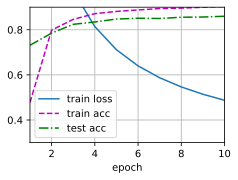

In [ ]:
num_epochs =10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


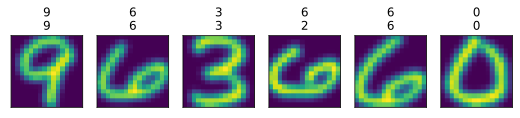

In [ ]:
def predict_ch3(net, test_iter, n=6):
  for X,y in test_iter:
    break
  trues = get_usps_labels(y)
  preds = get_usps_labels(net(X).argmax(axis=1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(
      X[0:n].reshape((n, 16, 16)),1,n,titles=titles[0:n])
  
predict_ch3(net, test_iter)

#Concise Implementation of Softmax Regression

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
batch_size = 400 
train_iter, test_iter = load_data_usps(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(256, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.3)

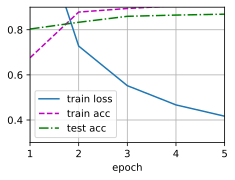

In [ ]:
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)